<a target="_blank" href="https://colab.research.google.com/github/23wc01/CMPSC7540/blob/main/my_XOR_FCN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Given code**

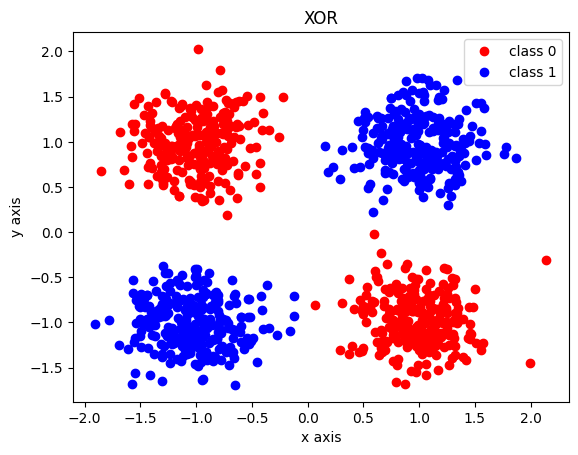

In [75]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)
X = rng.randn(1000, 2)
X = (X > 0) * 2 - 1 + 0.3 * rng.randn(*X.shape)
Y = np.logical_xor(X[:,0] > 0, X[:,1] > 0).astype(int)

c0 = X[np.nonzero(Y)[0]]
c1 = X[np.nonzero(Y == 0)[0]]

plt.plot(c0[:,0], c0[:,1], "ro", label="class 0")
plt.plot(c1[:,0], c1[:,1], "bo", label="class 1")

plt.title("XOR")
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.legend()
plt.show()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size=8

training_data = DataLoader(TensorDataset(torch.Tensor(X[:750,:]), torch.tensor(Y[:750], dtype=torch.long)), shuffle=True, batch_size=batch_size)
validation_data = DataLoader(TensorDataset(torch.Tensor(X[750:,:]), torch.tensor(Y[750:], dtype=torch.long)), batch_size=batch_size)

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.first_hidden = nn.Linear(2, 3) # Previous 2,10
        #self.second_hidden = nn.Linear(10, 5) # Previous 10,5
        self.output = nn.Linear(3, 2) # Previous 5,2

    def forward(self, x):
        x = self.activation(self.first_hidden(x))
        #x = self.activation(self.second_hidden(x))
        x = self.output(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (activation): ReLU()
  (first_hidden): Linear(in_features=2, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=2, bias=True)
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data, model, loss_fn, optimizer)
    test(validation_data, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.700196  [    0/  750]
Test Error: 
 Accuracy: 65.2%, Avg loss: 0.636159 

Epoch 2
-------------------------------
loss: 0.570173  [    0/  750]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.445764 

Epoch 3
-------------------------------
loss: 0.455759  [    0/  750]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.235951 

Epoch 4
-------------------------------
loss: 0.227649  [    0/  750]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.138350 

Epoch 5
-------------------------------
loss: 0.060373  [    0/  750]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.095331 

Epoch 6
-------------------------------
loss: 0.094638  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.073548 

Epoch 7
-------------------------------
loss: 0.042235  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.060140 

Epoch 8
-------------------------------
loss: 0.034973  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.051220 

Epoch 9
----------------

In [9]:
def predict(x):
    #Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor).to(device)
    #Predict and return ans
    ans = torch.argmax(model(x), dim=1)
    return ans.to("cpu").detach().numpy()

In [10]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func,X,Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.title("XOR")
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    # Plot ground truth
    c0 = X[np.nonzero(Y)[0]]
    c1 = X[np.nonzero(Y == 0)[0]]
    plt.plot(c0[:,0], c0[:,1], "ko", label="class 0")
    plt.plot(c1[:,0], c1[:,1], "wo", label="class 1")
    plt.legend()

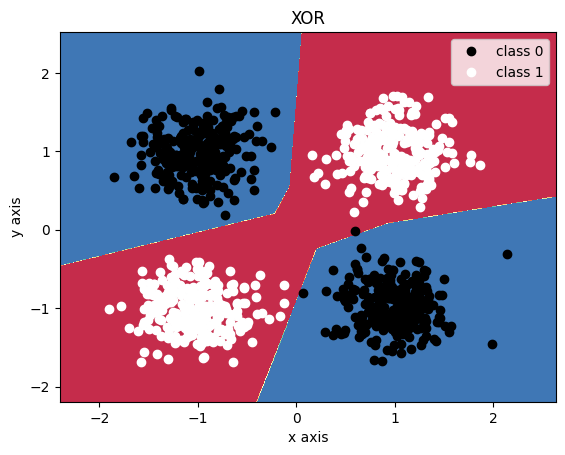

In [11]:
plot_decision_boundary(predict, X, Y)

# **RESPONSE**

Network to solve XOR problem

In [78]:
import matplotlib.lines as mlines  # For creating custom legend entries

def sigmoid(x):
        return 1 / (1 + np.exp(-x))

def perceptron(weights, bias, X):
    return sigmoid(np.dot(weights, X) + bias)

def xor_network(x1, x2):
    # Manually selected weights and biases
    hidden_weights = np.array([[20, -20], [-20, 20]])
    hidden_biases = np.array([-30, -30])
    output_weights = np.array([20, 20])
    output_bias = -0.008

    # Compute hidden layer outputs
    hidden_outputs = np.array([perceptron(hidden_weights[i], hidden_biases[i], [x1, x2]) for i in range(2)])

    # Compute final output
    output = perceptron(output_weights, output_bias, hidden_outputs)

    return round(output)  # Rounding to get binary output (0 or 1)

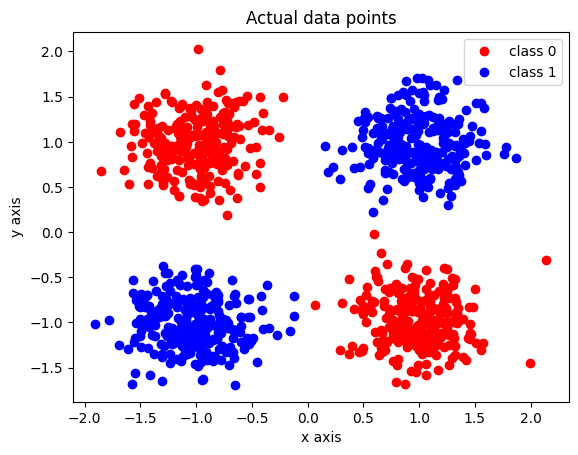

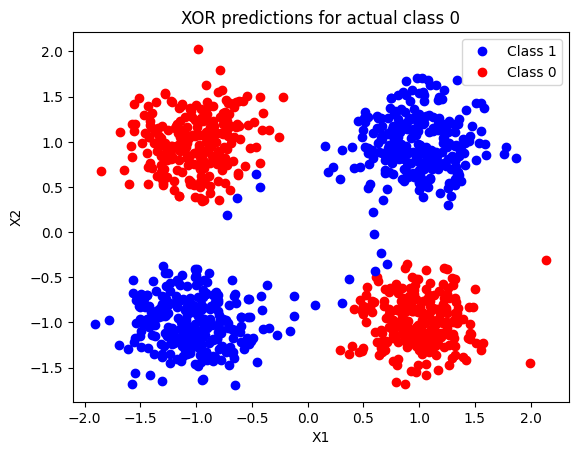

In [77]:
plt.plot(c0[:,0], c0[:,1], "ro", label="class 0")
plt.plot(c1[:,0], c1[:,1], "bo", label="class 1")

plt.title("Actual data points")
plt.xlabel("x axis")
plt.ylabel("y axis")
plt.legend()
plt.show()


red_point = mlines.Line2D([], [], color="red", marker="o", linestyle=" ", markersize=6, label="Class 0")
blue_point = mlines.Line2D([], [], color="blue", marker="o", linestyle=" ", markersize=6, label="Class 1")


# Iterate through points in class_0
for x1, x2 in X:
    prediction = xor_network(x1, x2)
    #print(f"({x1}, {x2}) = {prediction}")
    plt.scatter(x1, x2, c="blue" if prediction == 0 else "red")
plt.title("XOR predictions for actual class 0")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(handles=[blue_point, red_point]) # Adding the custom legend for labeling points
plt.show()